In [1]:
import vtk
from Parser import Parser
from ipycanvas import Canvas
from typing import Dict, Callable, Tuple, List
from ipywidgets import Image, Output
import ipywidgets as widgets
import numpy as np
import math
import asyncio
from time import time
from vtk.util import numpy_support
import matplotlib.pyplot as plt 

output = Output()

MOVE_ACTION = 'move'
ZOOM_ACTION = 'zoom'
SELECT_ACTION = 'select'
ROTATE_ACTION = 'rotate'

VISIBLE_CELL = "cell"

def defaultColorMap(cells, variables):
    return [
        ('#004400', 'green', cells[variables['cycle_model']] == 5),
        ('brown', 'black', cells[variables['cycle_model']] == 100),
        ('#440000', 'red', cells[variables['cycle_model']] == 101)
    ]

def noFilter(cells, variables):
    return np.full(cells.shape[1], True)

def count(array):
    dic = {}
    for num in array:
        if not num in dic:
            dic[num] = 0
        dic[num] += 1
    return dic
    

class Interactor2D:
    def __init__(self, parser, width: int = 500, height: int = 400, colorMap = defaultColorMap, filterFunction = None):
        self._currentFrame = parser.getFrameRange()[0]
        self._canvas = Canvas(width=width, height=height)
        self._parser = parser
        self._colorMap = colorMap
        self._height = height
        self._width = width
        self._filterFunction = filterFunction
        
        frame = parser.getFrame(self._currentFrame)
        mesh = frame.environment.mesh
        self._availableEnvironments = [*frame.environment.current.attributes]
        self._zoom = max((mesh.boundsX[1] - mesh.boundsX[0]) / width, (mesh.boundsY[1] - mesh.boundsY[0]) / height)
        
        self._xOffset = mesh.boundsX[0]
        self._yOffset = mesh.boundsY[0]
        self._selectedCell = None
        self._totalVolume = 0
        self._cellPhase = None
        
        self._clicking = False
        self._dragStartX = 0
        self._dragStartY = 0
        self._actionOriginX = 0
        self._actionOriginY = 0
        
        self._canvas.on_mouse_down(self.onMouseDown)
        self._canvas.on_mouse_move(self.onMouseMove)
        self._canvas.on_mouse_up(self.onMouseUp)
        self._canvas.on_mouse_out(self.onMouseOut)
        
        self.action = MOVE_ACTION
        
        self._buttons = widgets.RadioButtons(
            options=[MOVE_ACTION, ZOOM_ACTION, SELECT_ACTION],
            value=self.action,
            description='Mouse Action:',
            disabled=False,
        )
        self._buttons.observe(self.onToolChange, names='value')
        
        self._visible = (VISIBLE_CELL,)
        self._environmentButtons = widgets.SelectMultiple(
            options=[VISIBLE_CELL, *self._availableEnvironments],
            description='Visible:',
            disabled=False,
            value=[VISIBLE_CELL],
        )
        self._environmentButtons.observe(self.onVisibilityChange, names='value')
        
        self._availableAttributes = [*frame.cells.variables.keys()]
        self._attributes = widgets.RadioButtons(
            options=self._availableAttributes ,
            value= self._availableAttributes[0],
            description='Generate Attribute Graph:\n',
            disabled=False,
        )
        self._attributes.observe(self.onAttriChange, names='value')

        self._frameSelector = widgets.IntSlider(
            value=self._currentFrame,
            min=parser.getFrameRange()[0],
            max=parser.getFrameRange()[1] - 1,
            step=1,
            description='Frame:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        self._frameSelector.observe(self.onFrameChange, names='value')
        
        self.update()
    
    @output.capture()
    def drawEnvironment(self, attribute, rRange=(0,0), gRange=(0,255), bRange=(0,255), aRange=(0, 255)):
        if attribute is None:
            return
        canvas = self._canvas
        
        canvas.save()
        
        environment = self._parser.getFrame(self._currentFrame).environment

        xbounds = environment.mesh.boundsX
        ybounds = environment.mesh.boundsY
        
        attributeIndex = environment.current.variables[attribute]

        positions = environment.mesh.voxels
        data = environment.current.data[attributeIndex]

        xCount = np.unique(environment.mesh.voxels[environment.mesh.variables['x']]).shape[0]
        yCount = np.unique(environment.mesh.voxels[environment.mesh.variables['y']]).shape[0]

        minimum = np.min(data)
        maximum = np.max(data)

        shapedData = np.reshape(data / maximum, (xCount, yCount))

        image_data = np.stack((shapedData * (rRange[1] - rRange[0]) + rRange[0], shapedData * (gRange[1] - gRange[0]) + gRange[0], shapedData * (bRange[1] - bRange[0]) + bRange[0], shapedData * (aRange[1] - aRange[0]) + aRange[0]), axis=2)
        image_data = image_data.astype(dtype=np.int32)

        canvas.save()
        
        scale = (xbounds[1] - xbounds[0]) / ( xCount * self._zoom )
        
        canvas.scale( scale )
        
        x = (xbounds[0] - self._xOffset) / (scale * self._zoom)
        y = (ybounds[0] - self._yOffset) / (scale * self._zoom)

        canvas.put_image_data(image_data, x,  y)

        canvas.restore()
        
        canvas.fill_style = '#A0A0A0'
        canvas.font = '10px serif'
        canvas.fill_text(f"(x: {x}, y: {y}, s: {scale})", 10, 10)
    
    def drawCells(self):
        canvas = self._canvas
        frame = self._parser.getFrame(self._currentFrame)
    
        cells = frame.cells.data
        cellVariables = frame.cells.variables
        
        if self._filterFunction:
            cells = cells[:,self._filterFunction(cells, cellVariables)]
        
        canvas.stroke_style = 'blue'

        x = (cells[cellVariables['position.x']] - self._xOffset) / self._zoom
        y = (cells[cellVariables['position.y']] - self._yOffset) / self._zoom
        r = self.radiusOfCells(cells, cellVariables) / self._zoom
        
        combined = np.array([x, y, r])
        
        for fill, stroke, indices in self._colorMap(cells, cellVariables):
            split = combined[:,indices]
            if split.shape[0] == 0:
                continue
            x, y, r = split
            canvas.fill_style = fill
            canvas.fill_circles(x, y, r)
            canvas.stroke_style = stroke
            canvas.stroke_circles(x, y, r)
        
    
    def update(self):
        canvas = self._canvas
        
        canvas.clear()
        
        shouldDrawCells = False
        for element in self._visible:
            if element == VISIBLE_CELL:
                shouldDrawCells = True
                continue
            self.drawEnvironment(element)
            
        
        if shouldDrawCells:
            self.drawCells()
        
        canvas.fill_style = '#A0A0A0'
        canvas.font = '10px serif'
        canvas.fill_text(f"(X: {self._xOffset}, Y: {self._yOffset}, Zoom: {self._zoom}, ID: {self._selectedCell}, Volume: {self._totalVolume}, Cell Phase {self._cellPhase})", 10, self._height - 10)
    

    def setColorMap(colorMap):
        self._colorMap = colorMap
        self.update()
    
    def setFilterFunction(filterFunction):
        self._filterFunction = filterFunction
        self.update()
        
    def onMouseDown(self, x: int, y: int):
        self._dragStartX = x
        self._dragStartY = y
        self._envActionOriginX = x * self._zoom + self._xOffset
        self._envActionOriginY = y * self._zoom + self._yOffset
        self._actionOriginX = x
        self._actionOriginY = y
        self._actionOriginZoom = self._zoom
        
        if self.action == SELECT_ACTION:
            self.selectCell(self._envActionOriginX, self._envActionOriginY)
        else:
            self._clicking = True
    
    def onMouseUp(self, x: int, y: int):
        self._clicking = False
    
    def onMouseOut(self, x: int, y: int):
        self._clicking = False
    
    def onMouseMove(self, x: int, y: int):
        if self._clicking:
            if self.action == MOVE_ACTION:
                self._xOffset -= (x - self._dragStartX) * self._zoom
                self._yOffset -= (y - self._dragStartY) * self._zoom
            elif self.action == ZOOM_ACTION:
                self._zoom = max(self._actionOriginZoom * 2 ** ((self._actionOriginY - y) / 25), 0.0001)
                self._xOffset = self._envActionOriginX - self._actionOriginX * self._zoom
                self._yOffset = self._envActionOriginY - self._actionOriginY * self._zoom
                
            self._dragStartX = x
            self._dragStartY = y
            self.update()
    
    def onToolChange(self, action):
        self.action = action.new
    
    @output.capture()
    def onVisibilityChange(self, action):
        self._visible = action.new
        self.update()
        
    @output.capture()    
    def onAttriChange(self, action):
        selCellID = int(self._selectedCell)
        attribute = action.new
        data = []
        timestamps = []
        time = 0
        for frameNumber in range(*self._parser.getFrameRange()):
            cells = self._parser.getFrame(frameNumber).cells
            data.append(cells.data[cells.variables[attribute]][selCellID])
            timestamps.append(time)
            time += 1
        plt.xlabel("Time")
        plt.ylabel(attribute)
        plt.plot(timestamps, data)
        
        
    def onFrameChange(self, action):
        self._currentFrame = action.new
        self.update()
    
    def selectCell(self, x: float, y: float):
        frame = self._parser.getFrame(self._currentFrame)
    
        cells = frame.cells.data
        cellVariables = frame.cells.variables
        
        if self._filterFunction:
            cells = cells[:,self._filterFunction(cells, cellVariables)]
        
        distances = np.sqrt(np.square(x - cells[cellVariables['position.x']]) + np.square(y - cells[cellVariables['position.y']])) - self.radiusOfCells(cells, cellVariables)
        minIndex = np.argmin(distances)
        
        if distances[minIndex] <= 0:
            self._selectedCell = cells[cellVariables['ID'], minIndex]
            self._totalVolume = cells[cellVariables['total_volume'],minIndex]
            self._cellPhase = cells[cellVariables['current_phase'],minIndex]
            self.update()
        
 
    def radiusOfCells(self, cells, variables):
        return (cells[variables['total_volume']] * (3 / ( 4 * math.pi))) ** (1 / 3)

    def show(self):
        display(self._canvas, self._buttons, self._frameSelector,self._attributes, output, self._environmentButtons)

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def start(self):
        self._task = asyncio.ensure_future(self._job())

    def cancel(self):
        self._task.cancel()

def debounce(wait):
    """ Decorator that will postpone a function's
        execution until after `wait` seconds
        have elapsed since the last time it was invoked. """
    def decorator(fn):
        timer = None
        lastCall = time()
        def debounced(*args, **kwargs):
            nonlocal timer
            nonlocal lastCall
            def call_it():
                fn(*args, **kwargs)
            if timer is not None:
                timer.cancel()
            if time() - lastCall >= wait:
                lastCall = time()
                if timer is not None:
                    timer.cancel()
                call_it()
            else:
                timer = Timer(wait, call_it)
                timer.start()
        return debounced
    return decorator

@output.capture()
def defaultColorMap3d(cells, variables, selectedCellId):
    tags = vtk.vtkFloatArray()
    colors = np.zeros(cells.shape[1]) + (cells[variables['cycle_model']] == 5) + 2 * (cells[variables['cycle_model']] == 100) + 3 * (cells[variables['cycle_model']] == 101)
    if selectedCellId is not None:
        colors[cells[variables['ID']] == selectedCellId] = 4
    for cell in colors:
        tags.InsertNextValue(float(cell))
    
    
    colorTransferFunction = vtk.vtkColorTransferFunction()
    colorTransferFunction.AddRGBPoint(0.0, 0.0, 0.0, 0.0)
    colorTransferFunction.AddRGBPoint(1.0, 0.0, 1.0, 0.0)
    colorTransferFunction.AddRGBPoint(2.0, 165.0, 42.0, 42.0)
    colorTransferFunction.AddRGBPoint(3.0, 1.0, 0.0, 0.0)
    colorTransferFunction.AddRGBPoint(4.0, 1.0, 1.0, 1.0)
    
    return tags, colorTransferFunction

def defaultEnvironment(environment, attribute):
    xbounds = environment.mesh.boundsX
    ybounds = environment.mesh.boundsY
    zbounds = environment.mesh.boundsZ

    attributeIndex = environment.current.variables[attribute]

    positions = environment.mesh.voxels
    data = environment.current.data[attributeIndex]

    xCount = np.unique(environment.mesh.voxels[environment.mesh.variables['x']]).shape[0]
    yCount = np.unique(environment.mesh.voxels[environment.mesh.variables['y']]).shape[0]
    zCount = np.unique(environment.mesh.voxels[environment.mesh.variables['z']]).shape[0]

    minimum = np.min(data)
    maximum = np.max(data)
    
    if not maximum == 0:
        data = data / maximum

    data = np.reshape(data, (xCount, yCount, zCount))

    imdata = vtk.vtkImageData()
    depthArray = numpy_support.numpy_to_vtk(data.ravel(), deep=True, array_type=vtk.VTK_DOUBLE)

    imdata.SetDimensions(data.shape)
    imdata.SetSpacing([(xbounds[1] - xbounds[0]) / xCount, (ybounds[1] - ybounds[0]) / yCount, (zbounds[1] - zbounds[0]) / zCount])
    imdata.SetOrigin([xbounds[0], ybounds[0], zbounds[0]])
    imdata.GetPointData().SetScalars(depthArray)

    colorFunc = vtk.vtkColorTransferFunction()
    colorFunc.AddRGBPoint(0.0, 0.0, 0.0, 0.0)
    colorFunc.AddRGBPoint(1.0, 1.0, 1.0, 1.0)

    opacity = vtk.vtkPiecewiseFunction()
    opacity.AddPoint(0.0, 0.0)
    opacity.AddPoint(1, 0.8)

    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(colorFunc)
    volumeProperty.SetScalarOpacity(opacity)
    volumeProperty.SetInterpolationTypeToLinear()
    volumeProperty.SetIndependentComponents(2)

    volumeMapper = vtk.vtkFixedPointVolumeRayCastMapper()
    volumeMapper.SetInputData(imdata)
    volumeMapper.SetBlendModeToMaximumIntensity()


    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)
    
    return volume
    

class Interactor3D:
    def __init__(self, parser, width: int = 500, height: int = 400, colorMap = defaultColorMap3d, filterFunction = None):
        self._currentFrame = parser.getFrameRange()[0]
        self._canvas = Canvas(width=width, height=height)
        self._parser = parser
        self._colorMap = colorMap
        self._height = height
        self._width = width
        self._filterFunction = filterFunction
        
        self._selectedCell = None
        self._totalVolume = 0
        self._cellPhase = None
        
        self._clicking = False
        self._dragStartX = 0
        self._dragStartY = 0
        self._actionOriginX = 0
        self._actionOriginY = 0
        
        self._canvas.on_mouse_down(self.onMouseDown)
        self._canvas.on_mouse_move(self.onMouseMove)
        self._canvas.on_mouse_up(self.onMouseUp)
        self._canvas.on_mouse_out(self.onMouseOut)
        
        self.action = MOVE_ACTION
        
        self._availableEnvironments = [*parser.getFrame(self._currentFrame).environment.current.attributes]
        self._visible = (VISIBLE_CELL,)
        self._environmentButtons = widgets.SelectMultiple(
            options=[VISIBLE_CELL, *self._availableEnvironments],
            description='Visible:',
            disabled=False,
            value=[VISIBLE_CELL],
        )
        self._environmentButtons.observe(self.onVisibilityChange, names='value')
        self._previouslyVisible = None
        
        self._buttons = widgets.RadioButtons(
            options=[MOVE_ACTION, ROTATE_ACTION, ZOOM_ACTION, SELECT_ACTION],
            value=self.action,
            description='Mouse Action:',
            disabled=False,
        )
        self._buttons.observe(self.onToolChange, names='value')
    
        self._availableAttributes = [*parser.getFrame(self._currentFrame).cells.variables.keys()]
        self._attributes = widgets.RadioButtons(
            options=self._availableAttributes ,
            value= self._availableAttributes[0],
            description='Generate Attribute Graph:\n',
            disabled=False,
        )
        self._attributes.observe(self.onAttriChange, names='value')
        
        self._frameSelector = widgets.IntSlider(
            value=self._currentFrame,
            min=parser.getFrameRange()[0],
            max=parser.getFrameRange()[1] - 1,
            step=1,
            description='Frame:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        self._frameSelector.observe(self.onFrameChange, names='value')
        
        self._previousFrameNumber = -1
        self._previouslySelectedCell = None
        self._previousFilterFunction = None
        
        self.renderer = vtk.vtkRenderer()
        
        self.create(parser.getFrame(self._currentFrame))
        
        renderWindow = vtk.vtkRenderWindow()
        renderWindow.SetOffScreenRendering(1)
        renderWindow.AddRenderer(self.renderer)
        renderWindow.SetSize(width, height)
        renderWindow.Render()
        
        self.renderWindow = renderWindow
        
        self.update()
    
    def drawCells(self, frame):
        cells = frame.cells.data
        variables = frame.cells.variables
        
        if self._filterFunction:
            cells = cells[:,self._filterFunction(cells, variables)]
        
        x = variables["position.x"]
        y = variables["position.y"]
        z = variables["position.z"]
        r = self.radiusOfCells(cells, variables)
        
        data = vtk.vtkPolyData()
        points = vtk.vtkPoints()
        radii = vtk.vtkFloatArray()
        radii.SetName("radius")
        
        colors, lookupTable = self._colorMap(cells, variables, self._selectedCell)
        colors.SetName("color")
        
        for cell in range(cells.shape[1]):
            points.InsertNextPoint(cells[x,cell], cells[y, cell], cells[z, cell])
            radii.InsertNextValue(float(r[cell]))
        
        data.SetPoints(points)
        data.GetPointData().AddArray(radii)
        data.GetPointData().AddArray(colors)
        data.GetPointData().SetActiveScalars("color")
        
        # Source - ball
        ball = vtk.vtkSphereSource()
        ball.SetRadius(1)
        ball.SetThetaResolution(8)
        ball.SetPhiResolution(8)
        
        # Glyph - ball
        ballGlyph = vtk.vtkGlyph3D()
        ballGlyph.SetInputData(data)
        ballGlyph.SetScaleFactor(1)
        ballGlyph.ClampingOff()
        ballGlyph.SetColorModeToColorByScalar()
        ballGlyph.SetSourceConnection(ball.GetOutputPort())
        ballGlyph.SetInputArrayToProcess(0,0,0,0,'radius')
        ballGlyph.SetInputArrayToProcess(3,0,0,0,'color')
        
        # Mapper - ball
        ballMapper = vtk.vtkPolyDataMapper()
        ballMapper.SetInputData(data)
        ballMapper.SetInputConnection(ballGlyph.GetOutputPort())
        ballMapper.ScalarVisibilityOn()
        ballMapper.SetScalarModeToUsePointData()
        ballMapper.SelectColorArray("color")
        ballMapper.SetLookupTable(lookupTable)
        
        # Actor - ball
        ballActor = vtk.vtkActor()
        ballActor.SetMapper(ballMapper)
        
        self.renderer.AddActor(ballActor)
        
    
    def create(self, frameNumber):
        if frameNumber == self._previousFrameNumber and self._selectedCell == self._previouslySelectedCell and self._previousFilterFunction == self._filterFunction and self._previouslyVisible == self._visible:
            return
        
        self._previouslySelectedCell = self._selectedCell
        self.previousFrameNumber = frameNumber
        self._previousFilterFunction = self._filterFunction
        self._previouslyVisible = self._visible
        
        frame = self._parser.getFrame(self._currentFrame)
        
        self.renderer.RemoveAllViewProps()
        
        shouldDrawCells = False
        for element in self._visible:
            if element == VISIBLE_CELL:
                shouldDrawCells = True
                continue
            self.renderer.AddVolume(defaultEnvironment(frame.environment, element))
            
        
        if shouldDrawCells:
            self.drawCells(frame)
        
        self.renderer.ResetCameraClippingRange()
        
        
        
    @output.capture()
    def update(self):
        canvas = self._canvas
        canvas.clear()
        
        self.create(self._currentFrame)
        
        self.renderWindow.Render()
        
        windowToImageFilter = vtk.vtkWindowToImageFilter()
        windowToImageFilter.SetInput(self.renderWindow)
        windowToImageFilter.Update()

        writer = vtk.vtkPNGWriter()
        writer.SetWriteToMemory(1)
        writer.SetInputConnection(windowToImageFilter.GetOutputPort())
        writer.Write()
        
        data = memoryview(writer.GetResult()).tobytes()
        
        image = Image(value=data)
        
        canvas.draw_image(image)
            
        
        canvas.fill_style = '#A0A0A0'
        canvas.font = '10px serif'
        canvas.fill_text(f"(c: {self._selectedCell})", 10, self._height - 10)
    
    def setColorMap(colorMap):
        self._colorMap = colorMap
        self.update()
    
    def setFilterFunction(filterFunction):
        self._filterFunction = filterFunction
        self.update()
        
        
    
    @output.capture()
    def onMouseDown(self, x: int, y: int):
        self._dragStartX = x
        self._dragStartY = y
        self._actionOriginX = x
        self._actionOriginY = y
        
        if self.action == SELECT_ACTION:
            self.selectCell(x, self._height - y)
        else:
            self._clicking = True
    
    def onMouseUp(self, x: int, y: int):
        self._clicking = False
    
    def onMouseOut(self, x: int, y: int):
        self._clicking = False
    
    @output.capture()
    @debounce(0.2)
    def onMouseMove(self, x: int, y: int):
        if self._clicking:
            if self.action == MOVE_ACTION:
                self.pan(x, y)
            elif self.action == ZOOM_ACTION:
                self.renderer.GetActiveCamera().Zoom(1 + (self._actionOriginY - y) / 100)
            elif self.action == ROTATE_ACTION:
                self.rotate(x, y)
                
            self._dragStartX = x
            self._dragStartY = y
            self.update()
    
    def pan(self, x: float, y: float):
        # from https://compucell3d.org/BinDoc/cc3d_binaries/dependencies/windows/MinGW/dependencies_qt_4.8.4_pyqt_4.9.6_vtk_5.10.1_python27/Player/vtk/wx/wxVTKRenderWindow.py
        renderer = self.renderer
        camera = renderer.GetActiveCamera()
        (pPoint0,pPoint1,pPoint2) = camera.GetPosition()
        (fPoint0,fPoint1,fPoint2) = camera.GetFocalPoint()

        renderer.SetWorldPoint(fPoint0,fPoint1,fPoint2,1.0)
        renderer.WorldToDisplay()
        # Convert world point coordinates to display coordinates
        dPoint = renderer.GetDisplayPoint()
        focalDepth = dPoint[2]

        aPoint0 = self._width / 2 + (x - self._dragStartX)
        aPoint1 = self._height / 2 - (y - self._dragStartY)

        renderer.SetDisplayPoint(aPoint0,aPoint1,focalDepth)
        renderer.DisplayToWorld()

        (rPoint0,rPoint1,rPoint2,rPoint3) = renderer.GetWorldPoint()
        if (rPoint3 != 0.0):
            rPoint0 = rPoint0/rPoint3
            rPoint1 = rPoint1/rPoint3
            rPoint2 = rPoint2/rPoint3

        camera.SetFocalPoint((fPoint0 - rPoint0) + fPoint0,
                             (fPoint1 - rPoint1) + fPoint1,
                             (fPoint2 - rPoint2) + fPoint2)

        camera.SetPosition((fPoint0 - rPoint0) + pPoint0,
                           (fPoint1 - rPoint1) + pPoint1,
                           (fPoint2 - rPoint2) + pPoint2)
        
    def rotate(self, x: float, y: float):
        # from https://compucell3d.org/BinDoc/cc3d_binaries/dependencies/windows/MinGW/dependencies_qt_4.8.4_pyqt_4.9.6_vtk_5.10.1_python27/Player/vtk/wx/wxVTKRenderWindow.py
        renderer = self.renderer
        camera = renderer.GetActiveCamera()
        camera.Azimuth(self._dragStartX - x)
        camera.Elevation(y - self._dragStartY)
        camera.OrthogonalizeViewUp()

        renderer.ResetCameraClippingRange()
    
    def zoom(self, x: float, y: float):
        # from https://compucell3d.org/BinDoc/cc3d_binaries/dependencies/windows/MinGW/dependencies_qt_4.8.4_pyqt_4.9.6_vtk_5.10.1_python27/Player/vtk/wx/wxVTKRenderWindow.py
        
        renderer = self.renderer
        camera = renderer.GetActiveCamera()

        zoomFactor = math.pow(1.02,(0.5*(self._dragStartY - y)))
        self._CurrentZoom = self._CurrentZoom * zoomFactor

        if camera.GetParallelProjection():
            parallelScale = camera.GetParallelScale()/zoomFactor
            camera.SetParallelScale(parallelScale)
        else:
            camera.Dolly(zoomFactor)
            renderer.ResetCameraClippingRange()

        self._dragStartX = x
        self._dragStartY = y

        self.Render()
    
    def onToolChange(self, action):
        self.action = action.new
    
    def onFrameChange(self, action):
        self._currentFrame = action.new
        self.update()
    
    @output.capture()
    def selectCell(self, x: float, y: float):
        picker = vtk.vtkPropPicker()
        picker.Pick(x, y, 0, self.renderer)

        # get the new
        self.NewPickedActor = picker.GetActor()
        
        position = picker.GetPickPosition()
        
        if not picker.GetActor():
            self._selectedCell = None
            self.update()
            return
        
        x, y, z = picker.GetPickPosition()
            
        frame = self._parser.getFrame(self._currentFrame)
    
        cells = frame.cells.data
        cellVariables = frame.cells.variables
        
        distances = np.sqrt(np.square(x - cells[cellVariables['position.x']]) + np.square(y - cells[cellVariables['position.y']]) + np.square(z - cells[cellVariables['position.z']])) - self.radiusOfCells(cells, cellVariables)
        minIndex = np.argmin(distances)
        
        if distances[minIndex] <= 0:
            self._selectedCell = cells[cellVariables['ID'], minIndex]
            self._totalVolume = cells[cellVariables['total_volume'],minIndex]
            self._cellPhase = cells[cellVariables['current_phase'],minIndex]
            
        self.update()
        
        
 
    def radiusOfCells(self, cells, variables):
        return (cells[variables['total_volume']] * (3 / ( 4 * math.pi))) ** (1 / 3)

    def show(self):
        display(self._canvas, self._buttons, self._frameSelector,self._attributes, self._environmentButtons, output)
    
    @output.capture()
    def onVisibilityChange(self, action):
        self._visible = action.new
        self.update()
        
    @output.capture()    
    def onAttriChange(self, action):
        selCellID = int(self._selectedCell)
        attribute = action.new
        data = []
        timestamps = []
        time = 0
        for frameNumber in range(*self._parser.getFrameRange()):
            cells = self._parser.getFrame(frameNumber).cells
            data.append(cells.data[cells.variables[attribute]][selCellID])
            timestamps.append(time)
            time += 1
        plt.xlabel("Time")
        plt.ylabel(attribute)
        plt.plot(timestamps, data)
            

def InteractiveEnvironment(outputPath: str, width: int = 500, height: int = 400, force3d: bool = False, **kwargs):
    parser = Parser(outputPath)
    if parser.getFrame(parser.getFrameRange()[0]).environment.is2D and not force3d:
        return Interactor2D(parser, width, height, **kwargs)
    return Interactor3D(parser, width, height,**kwargs)

Canvas(height=800, width=800)

RadioButtons(description='Mouse Action:', options=('move', 'zoom', 'select'), value='move')

IntSlider(value=0, continuous_update=False, description='Frame:', max=9)

RadioButtons(description='Generate Attribute Graph:\n', options=('ID', 'position.x', 'position.y', 'position.z…

Output()

SelectMultiple(description='Visible:', index=(0,), options=('cell', 'oxygen'), value=('cell',))

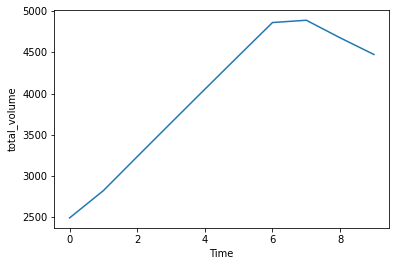

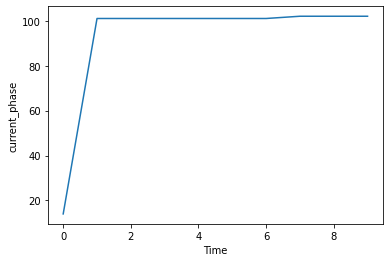

In [2]:
def filterFunction(cells, variables):
    return cells[variables['cycle_model']] == 5

env = InteractiveEnvironment('./sample-output', width=800, height=800)
env.show()

Canvas(height=800, width=800)

RadioButtons(description='Mouse Action:', options=('move', 'rotate', 'zoom', 'select'), value='move')

RadioButtons(description='Generate Attribute Graph:\n', options=('ID', 'position.x', 'position.y', 'position.z…

IntSlider(value=0, continuous_update=False, description='Frame:', max=5)

SelectMultiple(description='Visible:', index=(0,), options=('cell', 'oxygen', 'immunostimulatory factor'), val…

Output()

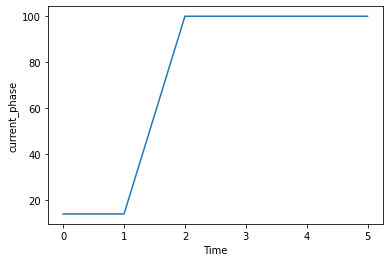

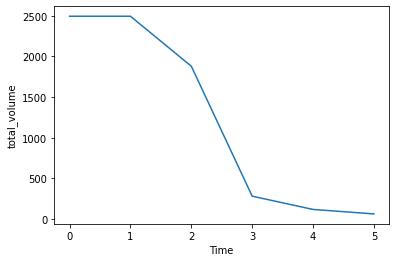

In [3]:
def filterFunction(cells, variables):
    return cells[variables['cycle_model']] == 5

env = InteractiveEnvironment('./sample-output-3d', width=800, height=800)
env.show()